# Spam Detection w/ BERT & Tensorflow

## Import the necessary packages

In [ ]:
%pip install tensorflow_text
import tensorflow as tf
import tensorflow_hub as tf_hub
import tensorflow_text as tf_text
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

     |████████████████████████████████| 4.9 MB 12.9 MB/s 
     |████████████████████████████████| 462 kB 50.7 MB/s 


## Download and prepare the dataset

Before we clean up our data, we want to check if there is a good balance between each category in our dataset. Having a class imbalance can lead to a situation where minimal "spam" samples are seen in training and our model might not be able to properly classify our test data.

In [ ]:
!curl -o spam.csv https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv

data = pd.read_csv('spam.csv', encoding='latin1')
data.head()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  491k  100  491k    0     0  2459k      0 --:--:-- --:--:-- --:--:-- 2459k


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
print('\nClass instances:')
print(data['v1'].value_counts())


Class instances:
ham     4825
spam     747
Name: v1, dtype: int64


Since our data only has 1 feature we can downsample the non-spam data to match the frequency of data labeled as spam. 

In [ ]:
data_non_spam = data[data['v1']=='ham']
data_spam = data[data['v1']=='spam']

data_non_spam_downsampled = data_non_spam.sample(data_spam.shape[0])
data = pd.concat([data_spam, data_non_spam_downsampled], ignore_index=True)

print('\nClass instances:')
print(data['v1'].value_counts())


Class instances:
spam    747
ham     747
Name: v1, dtype: int64


Taking a look at the top 5 entries, one might assume that the last 3 columns are all full of empty values and can thus be discarded. However, there are certain entries where the message is split between multiple columns (as seen below) so we want to join these together under the v2 column. 

In [ ]:
long_messages = data[~data[data.columns[2]].isna()]
example_index = long_messages.index[0]

print('Before: \n' + data.iloc[example_index][1])
data['v2'] = data[data.columns[1:]].apply(lambda x: ''.join(x.dropna().astype(str)), axis=1)
print('After: \n' + data.iloc[example_index][1])

Before: 
Your free ringtone is waiting to be collected. Simply text the password \MIX\" to 85069 to verify. Get Usher and Britney. FML
After: 
Your free ringtone is waiting to be collected. Simply text the password \MIX\" to 85069 to verify. Get Usher and Britney. FML PO Box 5249 MK17 92H. 450Ppw 16"


Now that we consolidated all the split messages into a single column, we can proceed to remove columns that contain empty values. We're also going to rename the columns to provide better context, and introduce a new column to one-hot encode our categorical data (spam vs non-spam) into a numerical value that our algorithms can process. For this case, we're going to label spam as 1.

In [ ]:
data.dropna(axis='columns', how='any', inplace=True)
data.rename(columns={'v1': 'Label', 'v2': 'Message'}, inplace=True)
data['Spam'] = data['Label'].apply(lambda x: 1 if x=='spam' else 0)
data.sample(5)

,Label,Message,Spam
949,ham,I've reached sch already...,0
488,spam,wamma get laid?want real doggin locations sent...,1
144,spam,money!!! you r a lucky winner ! 2 claim your p...,1
289,spam,85233 FREE>Ringtone!Reply REAL,1
108,spam,"Do you realize that in about 40 years, we'll h...",1


## Using BERT with a Neural Network
Now we can use BERT to create vectors (embeddings) for our messages. We use a pre-trained preprocessor that takes in strings, tokenizes them, and adds the necessary elements that our specific BERT model needs to vectorize them properly. The encoder takes in the output of the preprocessor as input, and is the one responsible for converting our textual data into numerical data that we can use in our neural network.

In [ ]:
msg_train, msg_test, spam_train, spam_test = train_test_split(data['Message'], data['Spam'], stratify=data['Spam'])

bert_preprocessor = tf_hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert_encoder = tf_hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

Below are some brief explanations of 2 layers in the network:

Dropout: a layer that will randomly set inputs to 0 (at a user-specified frequency) for each step during the training stage; this is often done to help prevent cases of overfitting.

Dense: a fully connected neural network layer



> Sidenote: the code in parenthesis at the end of each of these layers represent the layer that they are connected to. The dropout layer receives input from the embeddings, and the output layer receives input from the dropout layer. "Pooled_output" refers to the output vectors for the CLS token. For many classification tasks, the CLS token is able to capture enough context.

We are using the Keras Functional API to create our model. Notice the use of the sigmoid function for our output layer. This is because we are performing binary classification so it makes the most sense to use.


In [ ]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='Inputs')

preprocessed_text = bert_preprocessor(text_input) # Tokenize our strings and adds <CLS> and <SEP>
embeddings = bert_encoder(preprocessed_text) # Converts our tokenized strings into vectors

# Dropout(frequency)
dropout = tf.keras.layers.Dropout(0.1, name="Dropout")(embeddings['pooled_output'])

# Dense(# of neurons, activation function)
output = tf.keras.layers.Dense(1, activation='sigmoid', name='Dense')(dropout)

model = tf.keras.Model(inputs=[text_input], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Inputs (InputLayer)            [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['Inputs[0][0]']                 
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

To finalize our model and compile it we need to choose an optimizer and loss function. The job of an optimizer is to shape the model into the most accurate form it can be by adjusting things like the weights and learning rate. The optimizer works closely with the loss function since it needs to minimize the loss function. The loss function is an indicator of how well the model is performing.


> ADAM optimizer: The name translates to "adaptive moment estimation" and it utilizes the concept of momentum when calculating the gradients





In [ ]:
metrics = [tf.keras.metrics.BinaryAccuracy(name = 'accuracy'), tf.keras.metrics.Precision(name = 'precision'),
           tf.keras.metrics.Recall(name = 'recall')]

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
history = model.fit(msg_train, spam_train, epochs = 10)

Epoch 1/10
35/35 [==============================] - 54s 709ms/step - loss: 0.6877 - accuracy: 0.5652 - precision: 0.5635 - recall: 0.5786
Epoch 2/10
35/35 [==============================] - 24s 675ms/step - loss: 0.5415 - accuracy: 0.7705 - precision: 0.7720 - recall: 0.7679
Epoch 3/10
35/35 [==============================] - 24s 676ms/step - loss: 0.4622 - accuracy: 0.8339 - precision: 0.8076 - recall: 0.8768
Epoch 4/10
35/35 [==============================] - 24s 683ms/step - loss: 0.4184 - accuracy: 0.8705 - precision: 0.8609 - recall: 0.8839
Epoch 5/10
35/35 [==============================] - 24s 675ms/step - loss: 0.3803 - accuracy: 0.8777 - precision: 0.8640 - recall: 0.8964
Epoch 6/10
35/35 [==============================] - 24s 675ms/step - loss: 0.3504 - accuracy: 0.8830 - precision: 0.8705 - recall: 0.9000
Epoch 7/10
35/35 [==============================] - 24s 678ms/step - loss: 0.3331 - accuracy: 0.8964 - precision: 0.8868 - recall: 0.9089
Epoch 8/10
35/35 [================

## Making sense of our model

One of the best ways to determine if our model is any good is by analyzing the confusion matrix. 

Text(33.0, 0.5, 'Actual')

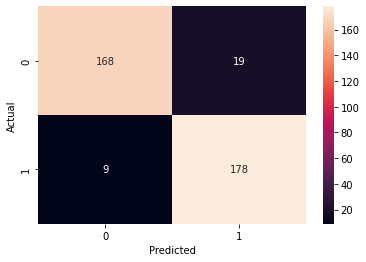

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sb

spam_predictions = model.predict(msg_test)
# We need to flatten the data to 1-dimension since the result of model.predict
# is 2-dimensional
spam_predictions = spam_predictions.flatten()

# Since we used the sigmoid function, any values above 0.5 would be classified
# as 1 which is spam. Values below 0.5 would not be classified as spam. 
spam_predictions = np.where(spam_predictions > 0.5, 1, 0)

matrix = confusion_matrix(spam_test, spam_predictions)
sb.heatmap(matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')

One sign that our model is working well is that we have a dense diagonal. For 19 of the samples, we classified them as spam even though they aren't actually spam. For 9 of the samples, we flagged them as non-spam even though they are actually spam. For this instance we have more scenarios where a user wouldn't receive a valid message because it was falsely marked as spam. 

## Trying messages I've received

Now that we have a trained model it is time to try it out on messages I've received recently that I think are spam:

In [ ]:
my_msg = [
          # Spam
          'Your WeIIs account is currently on hold due to an unauthorized login attempt. Reply WeIIs to receive a secure link to confirm your identity.',
          'Last Update: You have 12h left to claim the iPad 3 Pro 128GB which you Won in September:consentfasten.com/UjfBhNm',

          # Not Spam
          'Like that don’t expect even a B lol',
          'She starts school in July but in person august '
]


In [ ]:
results = model.predict(my_msg)
output = np.where(results > 0.5, 'spam', 'not-spam')
output

array([['spam'],
       ['spam'],
       ['not-spam'],
       ['not-spam']], dtype='<U8')

# Acknowledgements and Reflection
I had a lot of help from various internet sources for this assignment. I'll be completely honest and say that once I got to the neural network portion I didn't know how to move forward and had to heavily rely on a tutorial I found. However, I did my best to research as much as I could to understand what was going on and I feel like I learned a lot more about BERT and neural networks. We didn't cover NNs in-depth since they're not the focus of the class so I wanted to try to learn a little more about them. Reading the documentation for Keras was quite daunting since there are a lot of details and mathematics involved, but it was nice to work with their API.

One area that I'm still very interested in is how to design a good neural network. By this, I am referring to the overall structure since we can have any number of layers and neurons. I saw many examples of people using NNs for other projects, but they never explained how/why they used X amount of hidden layers and Y amount of neurons per layer. I did some brief research and a lot of people just said that finding those parameters comes along as a result of extensive experimentation. I have a friend who really wants to go to graduate school to research Machine Learning and I am starting to see why he finds it so interesting. 

One last thing that I learned because of this project is that GPUs are **KEY** if you ever want to train a model 😭 On my first run-through of the training process, I hadn't enabled the GPU acceleration and each epoch was estimated to take ~7 minutes long. I remembered that I could enable GPU accelaration and those times were cut down to ~30 secs per epoch. 


*   [Main Guide](https://www.analyticsvidhya.com/blog/2021/09/performing-email-spam-detection-using-bert-in-python/)
*   [Kaggle SMS Spam Dataset](https://github.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/blob/master/spam.csv)
*   [BERT Background](https://huggingface.co/blog/bert-101)
*   [BERT Visual Guide](https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/)
*   [Keras API](https://keras.io/api/)
*   [Sequential vs Functional Keras API](https://www.analyticsvidhya.com/blog/2021/07/understanding-sequential-vs-functional-api-in-keras/)


